# Аналитика данных мобильного приложения 

В данном проекте нам предстоит разобраться, как ведут себя пользователи мобильного приложения нашего стартапа, который занимается продажей продуктов питания.

Перед нам стоят следующие задачи:

1) Изучить воронку продаж: узнать как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно

2) Изучить результаты A/A/B-эксперимента, в котором проверяется реакция пользователей на изменение шрифта в приложении

## Шаг 1. Подготовка данных к анализу

### 1.1. Импорт библиотек и загрузка данных

Импортируем необходимые нам библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import re
from plotly import graph_objects as go
from scipy import stats as st
import math as mth

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
!pip install seaborn==0.11.1

Считаем данные

In [3]:
df = pd.read_csv('logs_exp.csv', sep='\t')

Выведем 5 первых строк датафрейма

In [4]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### 1.2. Внесение изменения в наименования

Поменяем названия столбцов на более понятные.

In [5]:
df.columns = ['event_name', 'user_id', 'event_unixtime', 'experiment_id']

Также заменим стиль обозначений названий событий на стиль snake case

In [6]:
for i in df['event_name'].unique():
    split_res = re.findall('[A-Z][^A-Z]*', i)
    df = df.replace(i, '_'.join(split_res).lower())

### 1.3. Добавление необходимых столбцов

Добавим столбец с датой и временем, преобразовав данные в столбце event_datetime из unix-времени в формат даты и времени.

In [7]:
df['event_datetime'] = pd.to_datetime(df['event_unixtime'], unit='s', origin='unix') 

### 1.4. Проверка корректности типов данных и наличия пропусков

Посмотрим на типы данных в каждом столбце.

In [8]:
df.dtypes

event_name                object
user_id                    int64
event_unixtime             int64
experiment_id              int64
event_datetime    datetime64[ns]
dtype: object

Мы видим, что сейчас в нашем датафрейме содержатся следующие столбцы:

* event_name — название события (obj);
* user_id — уникальный идентификатор пользователя (int64);
* event_unixtime - время события в формате unix time (int64)
* experiment_id — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная (int64)
* event_datetime — дата и время события (datetime64).

Все типы данных указаны корректно.

Также выделим в отдельный столбец дату событий.

In [9]:
df['event_date'] = df['event_datetime'].dt.date

In [10]:
df.head()

,event_name,user_id,event_unixtime,experiment_id,event_datetime,event_date
0,main_screen_appear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,main_screen_appear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,payment_screen_successful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,cart_screen_appear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,payment_screen_successful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Проверим данные на наличие пропусков

In [11]:
df.isna().sum()

event_name        0
user_id           0
event_unixtime    0
experiment_id     0
event_datetime    0
event_date        0
dtype: int64

Мы видим, что пропуски в нашем датафрейме отсутствуют.

### 1.5. Проверка на наличие дубликатов

Проверим, есть ли у нас в данных дублирующиеся строки.

In [12]:
df.duplicated().sum()

413

Мы видим, что у нас есть 413 дубликатов, посмотрим, что это за строки.

In [13]:
duplicates = df[df.duplicated(subset=None, keep=False)]
duplicates.head(10)

,event_name,user_id,event_unixtime,experiment_id,event_datetime,event_date
452,main_screen_appear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
453,main_screen_appear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
2348,cart_screen_appear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
2350,cart_screen_appear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
3572,main_screen_appear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01
3573,main_screen_appear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01
4075,main_screen_appear,3761373764179762633,1564631266,247,2019-08-01 03:47:46,2019-08-01
4076,main_screen_appear,3761373764179762633,1564631266,247,2019-08-01 03:47:46,2019-08-01
4801,main_screen_appear,2835328739789306622,1564634641,248,2019-08-01 04:44:01,2019-08-01
4803,main_screen_appear,2835328739789306622,1564634641,248,2019-08-01 04:44:01,2019-08-01


Мы видим, что некоторые пользователи совершили одно и то же действие в одну и ту же секунду. Однако, возможно, такие пользователи действительно могли два раза зайти на главную страницу в одно и то же время, например, случайно закрыв приложение, а потом сразу же снова зайдя в него. Но кажется маловероятным, что оплата могла быть произведена одним и тем же пользователем в одну и ту же секунду. Проверим, есть ли среди дубликатов действия с успешной оплатой.

In [14]:
duplicates[duplicates['event_name'] == "payment_screen_successful"].sort_values(by='event_unixtime').head(10)

,event_name,user_id,event_unixtime,experiment_id,event_datetime,event_date
5874,payment_screen_successful,6427012997733591237,1564638452,248,2019-08-01 05:47:32,2019-08-01
5875,payment_screen_successful,6427012997733591237,1564638452,248,2019-08-01 05:47:32,2019-08-01
9988,payment_screen_successful,7035352794299231933,1564647627,248,2019-08-01 08:20:27,2019-08-01
9990,payment_screen_successful,7035352794299231933,1564647627,248,2019-08-01 08:20:27,2019-08-01
12452,payment_screen_successful,5152160705477623487,1564652139,247,2019-08-01 09:35:39,2019-08-01
12454,payment_screen_successful,5152160705477623487,1564652139,247,2019-08-01 09:35:39,2019-08-01
13054,payment_screen_successful,6258460144399027762,1564653224,247,2019-08-01 09:53:44,2019-08-01
13055,payment_screen_successful,6258460144399027762,1564653224,247,2019-08-01 09:53:44,2019-08-01
15302,payment_screen_successful,8125832085431322921,1564657270,246,2019-08-01 11:01:10,2019-08-01
15304,payment_screen_successful,8125832085431322921,1564657270,246,2019-08-01 11:01:10,2019-08-01


Да, действительно, в данных есть пользователи, для которых существует два события оплаты в одно и то же время. Вероятно, могла возникнуть ошибка при выгрузке данных, о чем нужно будет сообщить коллегам. Исключим дубликаты из дальнейшего анализа.

In [15]:
df = df.drop_duplicates().reset_index(drop = True)

### Вывод

На данном этапе мы:
* импортировали необходимые для дальнейшего анализа библиотеки
* загрузили датасет
* переименовали столбцы и поменяли стиль записи в наименовании событий
* добавили столбцы 1) с датой и временем событий 2) с датой событий
* проверили, что в данных отсутствуют пропуски
* обнаружили, что среди наблюдений есть полные дубликаты, и исключили их из дальнейшего анализа

## Шаг 2. Изучение и проверка данных

### 2.1. Количество событий

Определим, сколько всего собыйтий (наблюдений) в логе.

In [16]:
print('Количество событий в логе: {:,}'.format(len(df)))

Количество событий в логе: 243,713


### 2.2. Количество пользователей

Посмотрим, сколько всего пользователей в логе.

In [17]:
print('Всего пользователей в логе {:,}'.format(df['user_id'].nunique()))

Всего пользователей в логе 7,551


### 2.3. Среднее количество событий на пользователя

Посчитаем сколько в среднем приходится событий на пользователя.

In [18]:
df_by_users = df.groupby('user_id', as_index=False).agg({'event_name': 'count'})

In [19]:
events_number_mean = df_by_users['event_name'].mean()
events_number_median = df_by_users['event_name'].median()

In [20]:
print('Среднее количество событий на пользователя {:.2f}'.format(events_number_mean))
print('Медианное количество событий на пользователя {:.2f}'.format(events_number_median))
print('Разница между средним и медианой {:.2%}'.format(events_number_mean / events_number_median - 1))

Среднее количество событий на пользователя 32.28
Медианное количество событий на пользователя 20.00
Разница между средним и медианой 61.38%


Мы видим, что среднее значение количества событий значительно выше медианного количества, то есть в данных есть некоторые пользователи с очень большим количеством событий. Посмотрим на распределение значений числа событий на пользователя.

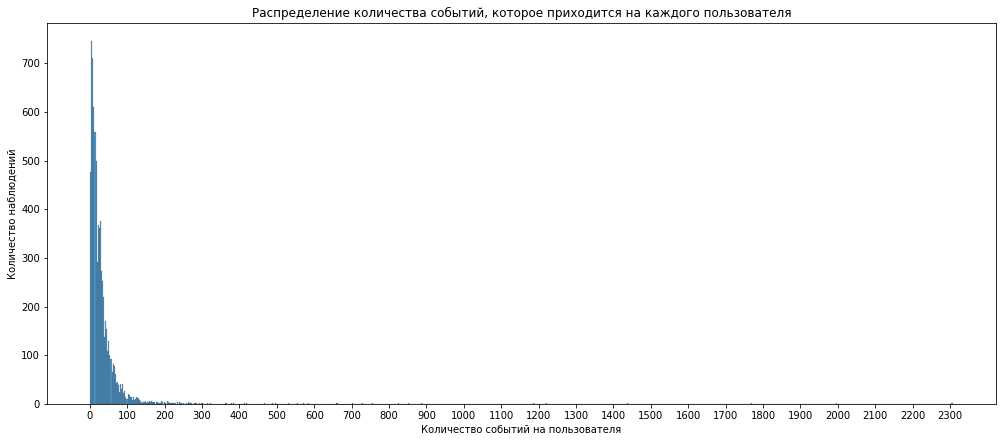

In [21]:
plt.figure(figsize=(17, 7))

ax = sns.histplot(x='event_name', data=df_by_users)

ax.set_title('Распределение количества событий, которое приходится на каждого пользователя')
ax.set_xlabel('Количество событий на пользователя')
ax.set_ylabel('Количество наблюдений')

plt.xticks(
    np.arange(
        0, 
        df_by_users['event_name'].max(),
        100)
)


plt.show()

Мы видим, что данные сгруппированы очень плотно - большая часть наблюдений находится в диапазоне от 0 до 50 событий на пользователя, наблюдается правосторонняя ассиметрия - в данных есть пользователи, на которых приходится аномально большое количество событий. Из-за этого среднее значение количества событий на пользователя значительно больше медианного значения.

### 2.4. Определение временного периода для анализа

Определим, данными за какой период мы располагаем: найдем минимальную и максимальную дату.

In [22]:
print('Самая ранняя дата: {}'.format(df['event_date'].min()))
print('Самая поздняя дата: {}'.format(df['event_date'].max()))

Самая ранняя дата: 2019-07-25
Самая поздняя дата: 2019-08-07


В наших данных содержатся события за две недели с 25 июля по 7 августа 2019 г.

Построим гистограмму по дате и времени.

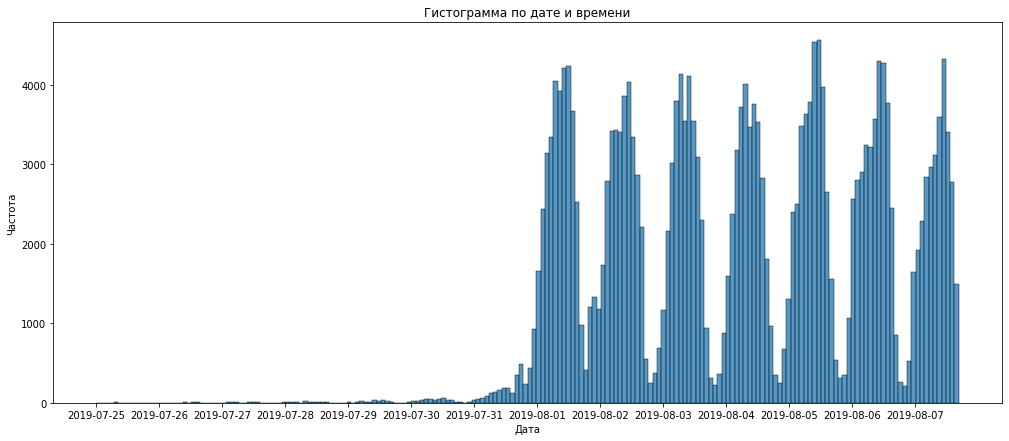

In [23]:
plt.figure(figsize=(17, 7))

ax = sns.histplot(x="event_datetime", data=df, bins=200)

ax.set_title('Гистограмма по дате и времени')
ax.set_xlabel('Дата')
ax.set_ylabel('Частота')

plt.xticks(
    np.arange(
        df['event_datetime'].min(), 
        df['event_datetime'].max(),
        np.timedelta64(1, 'D'))
)


plt.show()

На графике мы видим, что у нас очень мало данных до 1 августа 2019 г., поэтому мы не можем утверждать, что у нас имеются полные данные за весь период. Возможно, данные загружались с некоторым временным лагом, поэтому мы видим большое количество наблюдений только начиная с 1 августа. Определим в качестве периода для анализа промежуток с 1 по 7 августа 2019 г. , так как количество наблюдений в этот период примерно одинаково в каждый день и значительно больше числа наблюдений в период до 1 августа. 

In [24]:
df_august = df.query('event_datetime >= "2019-08-01 00:00:00"')

Проверим, сколько наблюдений и пользователей мы исключили, ограничив рассматриваемый временной промежуток.

In [25]:
events_total = len(df)
events_august = len(df_august)
user_total = len(df['user_id'].unique())
user_august = len(df_august['user_id'].unique())

In [64]:
print('Количество наблюдений уменьшилось на', 
      (events_total - events_august), 
      '- в процентном выражении на {:.2%}'.format(-(events_august / events_total - 1)))

print('Количество пользователей уменьшилось на', 
      (user_total - user_august), 
      '- в процентном выражении на {:.2%}'.format(-(user_august / user_total - 1)))

Количество наблюдений уменьшилось на 2826 - в процентном выражении на 1.16%
Количество пользователей уменьшилось на 17 - в процентном выражении на 0.23%


Проверим также, что ограничение рассматриваемого временного периода не привело к исключению какой-либо из экспериментальных групп и исключение данных было примерно одинаковым во всех группах.

Сгруппируем общие данные и данные только с 1 по 7 августа по группам эксперимента и посчитаем количество пользователей в каждой группе

In [27]:
df_experiments_total = df.groupby('experiment_id', as_index=False).agg({'user_id': 'nunique'})
df_experiments_total.columns = ['experiment_id', 'n_users_total']

In [28]:
df_experiments_august = df_august.groupby('experiment_id', as_index=False).agg({'user_id': 'nunique'})
df_experiments_august.columns = ['experiment_id', 'n_users_august']

In [29]:
df_experiments = df_experiments_total.merge(df_experiments_august, on='experiment_id')

In [30]:
df_experiments['change %'] = (df_experiments['n_users_total'] / df_experiments['n_users_august'] - 1) * 100

In [31]:
df_experiments

,experiment_id,n_users_total,n_users_august,change %
0,246,2489,2484,0.201288
1,247,2520,2513,0.278552
2,248,2542,2537,0.197083


Количество событий и пользователей, которых мы исключили, довольно мало - чуть больше 1% для количества событий и 0.2% для количества пользователей.

Также мы удостоверились в том, что ни одна из экспериментальных групп не была исключена из рассмотрения, а количество пользователей в каждой группе изменилось примерно одинаково - во всех группах оно сократилось не более, чем на 0.3%.

Исходя из этого мы можем сказать, что ограничение временного периода для анализа не должно привести к искаженным результатам. 

### Вывод

Таким образом, на данном этапе мы:
* Изучили среднее и медианное число событий на пользователя. Мы выяснили, что в данных есть отдельные пользователи, которые совершили значительно больше событий, чем основная часть пользователей, поэтому среднее значение событий на пользователя на 62% больше медианного. Среднее значение событий, которые совершает пользователь - 32, а медианное значение событий на пользователя - 20.
* Определили временной период для дальнейшего анализа данных - с 1 по 7 августа 2019 г. Данные за последнюю неделю июля мы исключили, так как мы не можем утверждать что данные одинаково полны на протяжении всего временного промежутка - количество наблюдений в июле значительно меньше, чем в августе. Мы также проверили что сужение рассматриваемого периода привело к исключению лишь небольшой части данных - 1% событий и 0.2% пользователей, и ни одна из экспериментальных групп не была исключена.

## Шаг 3. Изучение воронки событий

### 3.1. Анализ событий в логах

Посмотрим, какие уникальные события содержатся в логах.

In [32]:
df_august['event_name'].unique()

array(['tutorial', 'main_screen_appear', 'offers_screen_appear',
       'cart_screen_appear', 'payment_screen_successful'], dtype=object)

В данных содержатся следующие виды событий:
* main_screen_appear - показ главной страницы
* offers_screen_appear - показ страницы с товарами
* cart_screen_appear - показ корзины
* tutorial - показ страницы с часто задаваемыми вопросами
* payment_screen_successful - показ страницы с успешной оплатой

Изучим, как часто встречается каждое из событий.

In [33]:
events = df_august.groupby('event_name', as_index=False).agg({'event_datetime': 'count'})
events.columns = ['event_name', 'number_of_events']

events.sort_values(by='number_of_events', ascending=False)

,event_name,number_of_events
1,main_screen_appear,117328
2,offers_screen_appear,46333
0,cart_screen_appear,42303
3,payment_screen_successful,33918
4,tutorial,1005


Наиболее частое событие - показ главного экрана, затем следуют показ страниц с товарами, корзины, успешной оплатой и наименее часто встречаемое событие - показ страницы с F.A.Q.

Посчитаем, сколько пользователей совершили каждое из событий. 

In [34]:
events_by_users = df_august.groupby('event_name', as_index=False).agg({'user_id': 'nunique'})
events_by_users.columns = ['event_name', 'number_of_users']

events_by_users = events_by_users.sort_values(by='number_of_users', ascending=False)
events_by_users

,event_name,number_of_users
1,main_screen_appear,7419
2,offers_screen_appear,4593
0,cart_screen_appear,3734
3,payment_screen_successful,3539
4,tutorial,840


Порядок событий, отсортированный по количеству пользователей, такой же - показ главной страницы, показ страницы с товарами, показ страницы с корзиной, показ страницы с успешной оплатой, показ страницы с F.A.Q.

Посчитаем долю пользователей, которые хоть раз совершали определенное событие. Для этого поделим количество уникальных пользователей на каждом этапе на общее количество пользователей за наблюдаемый период.

In [35]:
events_by_users['total_number_of_users'] = df_august['user_id'].nunique()
events_by_users['total_conv%'] = events_by_users['number_of_users'] / events_by_users['total_number_of_users'] * 100

In [36]:
events_by_users

,event_name,number_of_users,total_number_of_users,total_conv%
1,main_screen_appear,7419,7534,98.473586
2,offers_screen_appear,4593,7534,60.963632
0,cart_screen_appear,3734,7534,49.561986
3,payment_screen_successful,3539,7534,46.973719
4,tutorial,840,7534,11.149456


Мы видим, что 98.5% пользователей совершали переход на главный экран, значительно меньше пользователей - 61% - переходили на страницу с товарами, 50% - переходили в корзину, 47% - оплачивали товары и только 11% переходили на страницу с вопросами.

### 3.2. Воронка событий

Определим возможный порядок событий. Ориентируясь на общую логику совершения покупок в приложениях и на данные по количеству пользователей на каждом этапе, можем предположить следующую цепочку событий:
* переход на главную страницу
* переход на страницу с товарами
* переход в корзину
* успешная оплата

При этом среди событий также есть переход на страницу с F.A.Q., однако мы можем предположить, что он не является обязательным звеном в цепочке событий, потому что в ином случае гораздо больше пользователей совершали бы данное событие, чтобы достичь этапа успешной оплаты. 

Посчитаем, какая доля пользователей проходит на каждый следующий шаг воронки. Так как мы решили, что переход на страницу с вопросами не является обязательным звеном воронки, исключим его из анализа воронки.

In [37]:
events_by_users = events_by_users[events_by_users['event_name'] != "tutorial"]

Создадим столбец 'previous_step', куда запишем данные по количеству пользователей на предыдущем шаге.

In [38]:
events_by_users = events_by_users.copy()

In [39]:
events_by_users['previous_step'] = events_by_users['number_of_users'].shift(1)

In [40]:
events_by_users['previous_step'] = events_by_users['previous_step'].fillna(events_by_users.loc[1, 'number_of_users'])

Разделим количество пользователей на текущем этапе воронки на количество пользователей на предыдущем. Так как для первого этапа - просмотра главной страницы - предыдущего события не существует, укажем 100% в качестве конверсии с предыдущего этапа.

In [41]:
events_by_users['previous_step_conv%'] = events_by_users['number_of_users'] / events_by_users['previous_step'] * 100

In [42]:
events_by_users

,event_name,number_of_users,total_number_of_users,total_conv%,previous_step,previous_step_conv%
1,main_screen_appear,7419,7534,98.473586,7419.0,100.000000
2,offers_screen_appear,4593,7534,60.963632,7419.0,61.908613
0,cart_screen_appear,3734,7534,49.561986,4593.0,81.297627
3,payment_screen_successful,3539,7534,46.973719,3734.0,94.777718


Визуализируем полученный результат.

In [67]:
fig = go.Figure(
    go.Funnel(
        y = events_by_users['event_name'], 
        x = events_by_users['number_of_users'], 
        textposition = "inside",
        textinfo = 'value+percent initial+percent previous'
    )
)

fig.update(layout_title_text='Воронка событий использования приложения', layout_title_x=0.5 )

fig.show()

На графике мы видим, что 62% пользователей осуществили переход с главной страницы на страницу с товарами, однако из тех, кто перешел на страницу с товарами, уже 81% пользователей перешел в корзину и из них 95% совершили оплату.

То есть больше всего пользователей "теряется" на этапе просмотра главной страницы - 38% просто не переходят на страницу с товарами. Возможно, пользователей отталкивает дизайн главной стрницы или им непонятно, в какой раздел перейти, чтобы начать просмотр товаров.

До последнего шага - успешной оплаты заказа доходят 95% тех, кто перешел до этого в корзину, то есть проблемы с просмотром корзины или процессом оплаты возникают только у малой части пользователей. Если рассматривать долю тех, кто совершили оплату, от общего количества пользователей, то мы видим, что 48% дошли от первого шага до успешной оплаты. При этом мы видим, что большая часть пользователей не преодолела шаг просмотра главной страницы.

### Вывод

На данном шаге мы проанализировали воронку событий:
* Определили последовательность событий на основе частотности и количества пользователей на каждом этапе. Цепочка выглядит следующим образом - переход на главную старницу, переход на страницу с товарами, переход в корзину, успешная оплата. Шаг с переходом на страницу вопросов является опциональным и не входит в этапы воронки.
* Вычислили долю пользователей на каждом этапе от общего количества пользователей и от количества пользователей на предыдущем шаге. Определили, что  до этапа успешной оплаты не доходят 52% пользователей: больше всего пользователей - 38% - "теряются" на этапе просмотра главной страницы.

## Шаг 4. Изучение результатов эксперимента

### 4.1. Статистическое сравнение контрольных групп

Определим, сколько пользователей в каждой экспериментальной группе.

In [44]:
df_august.groupby('experiment_id', as_index=False).agg({'user_id': 'nunique'})

,experiment_id,user_id
0,246,2484
1,247,2513
2,248,2537


У нас есть данные по А/А-эксперименту. Он необходим для больше точности в результатах тестирования, так мы будем более уверены в том, есть ли статистически значимая разница между контрольной и экспериментальной группами.

Для А/А-эксперимента есть две выборки - группы 246 и 247. Проверим, есть ли статистически значимая разница между этими группами с помощью z критерия, позволяющего проверить равенство долей в выборках.

Создадим два новых датафрейма - отдельно для группы 246 и отдельно для группы 247.

In [45]:
group_246 = df_august.query('experiment_id == 246')
group_247 = df_august.query('experiment_id == 247')

group_246.name = 'Группа 246'
group_247.name = 'Группа 247'

Выберем самое популярное событие - то, которое встречается в данных чаще всего. Далее сравним долю пользователей, совершивших данное собыйтие в группе 246 и группе 247.

In [46]:
events.sort_values(by='number_of_events', ascending=False)

,event_name,number_of_events
1,main_screen_appear,117328
2,offers_screen_appear,46333
0,cart_screen_appear,42303
3,payment_screen_successful,33918
4,tutorial,1005


Самое популярное событие - переход на главную страницу. 

Создадим функцию, которая будет подсчитывать долю пользователей, совершивших определенное событие, и определять, значима ли разница между долями на основании z-статистики.

In [68]:
def stat_diff_check(event_name, df1, df2):
    
    event_group1 = df1[df1['event_name'] == event_name]  
    event_group2 = df2[df2['event_name'] == event_name]
    
    success1 = event_group1['user_id'].nunique()  # кол-во пользователей, совершивших определенное событие в гр.1
    success2 = event_group2['user_id'].nunique()  # кол-во пользователей, совершивших определенное событие в гр.2
    
    trials1 = df1['user_id'].nunique()  # общее кол-во пользователей в гр.1
    trials2 = df2['user_id'].nunique()  # общее кол-во пользователей в гр.2
    
    print(df1.name, ': доля пользователей, совершивших действие', event_name, '{:.2%}'.format(success1 / trials1))
    print(df2.name, ': доля пользователей, совершивших действие', event_name, '{:.2%}'.format(success2 / trials2))
    
    print()
    
    alpha = 0.05 # уровень значимости
    
    bonferroni_alpha = alpha / 16  # с учетом того, что мы не рассматриваем туториал
    
    p1 = success1 / trials1  # пропорция успехов в гр.1

    p2 = success2 / trials2  # пропорция успехов в гр.2

    p_combined = (success1 + success2) / (trials1 + trials2) # пропорция успехов в комбинированном датасете

    difference = p1 - p2  # разница пропорций в датасетах

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Нулевая гипотеза: нет стат. значимой разницы между долями пользователей, совершивших действие {}'
          .format(event_name))
    print('Альтернативная гипотеза: есть стат. значимая разница между долями пользователей, совершивших действие {}'
          .format(event_name))
    
    print()

    print('p-значение: ', p_value)

    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

Вызовем функцию для самого популярного собыйтия - переход на главную страницу.

In [69]:
events = ['main_screen_appear', 'offers_screen_appear', 'cart_screen_appear', 'payment_screen_successful']

In [70]:
for i in events:
    stat_diff_check(i, group_246, group_247)

Группа 246 : доля пользователей, совершивших действие main_screen_appear 98.63%
Группа 247 : доля пользователей, совершивших действие main_screen_appear 98.53%

Нулевая гипотеза: нет стат. значимой разницы между долями пользователей, совершивших действие main_screen_appear
Альтернативная гипотеза: есть стат. значимая разница между долями пользователей, совершивших действие main_screen_appear

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группа 246 : доля пользователей, совершивших действие offers_screen_appear 62.08%
Группа 247 : доля пользователей, совершивших действие offers_screen_appear 60.49%

Нулевая гипотеза: нет стат. значимой разницы между долями пользователей, совершивших действие offers_screen_appear
Альтернативная гипотеза: есть стат. значимая разница между долями пользователей, совершивших действие offers_screen_appear

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований с

На основании проведенных тестов для долей пользователей, совершивших определенное собыйтие, в контрольных группах 246 и 247, мы можем сказать, что нет статистически значимой разницы между указанными группами. Таким образом, разделение на группы было корректным, и мы можем быть уверены в точности дальнейшего тестирования при сравнении данных с экспериментальной группой 248.

### 4.2. Статистическое сравнение с экспериментальной группой

Выделим отдельно группу 248 и создадим датафрейм с данными по этой группе. Удостоверимся, что в сумме количество строк в датафреймах по каждой экспериментальной группе, дает общее количество строк в анализируемом датафрейме.

In [50]:
group_248 = df_august.query('experiment_id == 248')
group_248.name = 'Группа 248'

len(group_248) + len(group_247) + len(group_246) == len(df_august)

True

Сравним результаты группы 248 с каждой из контрольных груп по каждому собыйтию.

Для начала сравним доли пользователей, совершивших определенное событие, в группах 246 и 248.

In [51]:
for i in events:
    stat_diff_check(i, group_246, group_248)

Группа 246 : доля пользователей, совершивших действие main_screen_appear 98.63%
Группа 248 : доля пользователей, совершивших действие main_screen_appear 98.27%

Нулевая гипотеза: нет стат. значимой разницы между долями пользователей, совершивших действие main_screen_appear
Альтернативная гипотеза: есть стат. значимая разница между долями пользователей, совершивших действие main_screen_appear

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группа 246 : доля пользователей, совершивших действие offers_screen_appear 62.08%
Группа 248 : доля пользователей, совершивших действие offers_screen_appear 60.35%

Нулевая гипотеза: нет стат. значимой разницы между долями пользователей, совершивших действие offers_screen_appear
Альтернативная гипотеза: есть стат. значимая разница между долями пользователей, совершивших действие offers_screen_appear

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований 

Сделаем такое же сравнение с группой 247.

In [52]:
for i in events:
    stat_diff_check(i, group_247, group_248)

Группа 247 : доля пользователей, совершивших действие main_screen_appear 98.53%
Группа 248 : доля пользователей, совершивших действие main_screen_appear 98.27%

Нулевая гипотеза: нет стат. значимой разницы между долями пользователей, совершивших действие main_screen_appear
Альтернативная гипотеза: есть стат. значимая разница между долями пользователей, совершивших действие main_screen_appear

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группа 247 : доля пользователей, совершивших действие offers_screen_appear 60.49%
Группа 248 : доля пользователей, совершивших действие offers_screen_appear 60.35%

Нулевая гипотеза: нет стат. значимой разницы между долями пользователей, совершивших действие offers_screen_appear
Альтернативная гипотеза: есть стат. значимая разница между долями пользователей, совершивших действие offers_screen_appear

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований с

Как мы видим, ни для одного из событий нет статистически значимой разницы в долях между экспериментальной группой и каждой из контрольных групп.

Теперь сравним экспериментальную группу с общей контрольной группой, создадим датафрейм, в котором будут храниться данные и по 246, и по 247 группам.

In [53]:
control_group = df_august.query('experiment_id != 248')
control_group.name = 'Общая контрольная группа'

In [54]:
for i in events:
    stat_diff_check(i, control_group, group_248)

Общая контрольная группа : доля пользователей, совершивших действие main_screen_appear 98.58%
Группа 248 : доля пользователей, совершивших действие main_screen_appear 98.27%

Нулевая гипотеза: нет стат. значимой разницы между долями пользователей, совершивших действие main_screen_appear
Альтернативная гипотеза: есть стат. значимая разница между долями пользователей, совершивших действие main_screen_appear

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Общая контрольная группа : доля пользователей, совершивших действие offers_screen_appear 61.28%
Группа 248 : доля пользователей, совершивших действие offers_screen_appear 60.35%

Нулевая гипотеза: нет стат. значимой разницы между долями пользователей, совершивших действие offers_screen_appear
Альтернативная гипотеза: есть стат. значимая разница между долями пользователей, совершивших действие offers_screen_appear

p-значение:  0.43425549655188256
Не получилось отвергнуть нул

Результаты сравнения объединенной контрольной группы с экспериментальной совпадают с предыдущими итогами сравнения экспериментальной группы с каждой из контрольных групп - нет статистически значимой разницы между долями пользователей, совершающих определенные собыйтия в разных группах.

В качестве критического уровня статистической значимости было выбрано значение 0.05, при этом была выполнена поправка Бонферрони для множественных тестов, так как для каждого события было осуществлено 4 попарных проверки (между 2 контрольными группами, между каждой из 2-х контрольных групп и экспериментальной группой, между экспериментальной группой и объединенной контрольной группой). 

### Вывод

На данном шаге мы проверили, есть ли статистически значимая разница между контрольными группами, сравнив долю пользователей для каждого события. Разницы между контрольными группами выявлено не было, то есть разделение на группы было корректным.

Также мы сравнили доли пользователей, совершивших определенное событие, в каждой из контрольной и экспериментальной группах. Статистически значимой разницы выявлено не было. 

Кроме того, было проведено сравнение долей между объединенной контрольной группой и экспериментальной группой. Здесь мы также не смогли отвергнуть нулевую гипотезу об отсутствии статистически значимой разницы между группами.

Таким образом, мы не можем утверждать, что изменение шрифтов привело к какому-либо значимому изменению в конверсии пользователей.

## Шаг 5. Общие выводы

Таким образом, в данном исследовании мы изучили, как ведут себя пользователи нашего мобильного приложения:

1) Провели подготовку данных к анализу - удостоверились, что в данных отсуствуют пропуски, исключили дублирующиеся строки, заменили названия столбцов на более понятные

2) Изучили, сколько в среднем событий совершает каждый из пользователей. Мы выяснили, что есть некоторое количество пользователей, совершивших аномально большое количество событий, из-за чего среднее значение количества действий значительно превышает медианное значение.

3) Определили период для анализа - мы оставили наблюдения только за период с 1 по 7 августа 2019 г., так как данных за предыдущий временной промежуток оказалось значительно меньше, чем за первую неделю августа.

4) Изучили воронку событий - определили, что последовательность событий следующая: просмотр главного экрана, просмотр предложений (товаров), просмотр корзины, успешная оплата. 

5) Выяснили, что больше всего пользователей (38%) уходят на этапе просмотра главного экрана

6) Проверили корректность выделения контрольных групп - статистически значимой разницы между ними не оказалось, то есть разделение было корректным

7) Сравнили доли пользователей для каждого действия в каждой из контрольной и экспериментальной группах, а также в объединенной контрольной и экспериментальной группах. Статистически значимой разницы найдено не было. Таким образом, изменение шрифта не привело к значимому изменению конверсии пользователей.